In [1]:
import pandas as pd 
import numpy as np
import csv
import matplotlib.pyplot as plt
#### Modelo
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
#Funcion para hacer merge de bases de datos
def MergeDB(output, dataframe, merge_col_name,important_cols):
    merged_df = output.merge(dataframe, on = merge_col_name, how = 'inner')
    merged_df = merged_df[important_cols]

    return merged_df

In [3]:
#Lee bases de datos
Iluminancia_pd = pd.read_csv("D:\home\[00]_Projects\[01]_School\MachineLearning\Bases_datos\Iluminancia.csv")
Output_pd = pd.read_csv("D:\home\[00]_Projects\[01]_School\MachineLearning\Bases_datos\outputActualizado.csv")

# Limpiamos la base de datos output

In [4]:
Output_pd = Output_pd.dropna()

In [5]:
##Tomamos valores numéricos
check_no_alpha = Output_pd['RoomID'].str.isnumeric()
Output_pd = Output_pd[check_no_alpha]

#Cambiamos el nombre de la columna de Room Id del output y le cambiamos el tipo
Output_pd['RoomID'] = Output_pd['RoomID'].astype('int64')

In [6]:
#Tomamos únicamente las columnas que queremos
significant = ['RoomID', 'MemoryAverage']

In [7]:
#Actualizamos la base
Output_pd = Output_pd[significant]

In [8]:
# Definir los límites de cuantiles para la estratificación
cuantiles = [0, 0.13, 0.4, 0.66, 1]
# Aplicar la estratificación basada en cuantiles
Output_pd['Grupo'] = pd.qcut(Output_pd['MemoryAverage'], cuantiles, labels=['Grupo_1', 'Grupo_2', 'Grupo_3', 'Grupo_4'])
# Imprimir la distribución de grupos
print(Output_pd['Grupo'].value_counts())

Grupo
Grupo_4    418
Grupo_2    413
Grupo_1    233
Grupo_3    212
Name: count, dtype: int64


In [9]:
# Convertir la columna de grupos a valores numéricos
Output_pd['Grupo'] = Output_pd['Grupo'].astype('category').cat.codes
# Los grupos se toman del 0 al 3, por lo que sumamos 1 para la representación de 1 a 4
Output_pd['Grupo'] = Output_pd['Grupo'] + 1
# Imprimir la distribución de grupos
print(Output_pd['Grupo'].value_counts())

Grupo
4    418
2    413
1    233
3    212
Name: count, dtype: int64


# Limpiar iluminancia pd y juntamos las bases

In [10]:
Iluminancia_pd.head()

,RoomID,Illuminance,Temperature,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,4,100 lx,3000 K,NaN,NaN,NaN
1,10,100 lx,4000 K,NaN,NaN,NaN
2,16,100 lx,6500 K,NaN,NaN,NaN
3,301,100 lx,7500 K,NaN,NaN,NaN
4,302,100 lx,9000 K,NaN,NaN,NaN


In [11]:
# Tomamos las columnas de Output y agregamos las importantes de iluminancia.csv
significant = Output_pd.columns.tolist()
significant.append('Illuminance')
significant.append('Temperature')

In [12]:
# Juntamos las bases de datos con la función del inicio
merged_pd = MergeDB(Output_pd, Iluminancia_pd, 'RoomID', significant)

In [13]:
# verificamos como quedaron los grupos distribuidos
merged_pd['Grupo'].value_counts()

Grupo
2    58
4    42
1    40
3    24
Name: count, dtype: int64

In [14]:
# Eliminamos las unidades y cambiamos el tipo de datos
merged_pd['Illuminance'] = merged_pd['Illuminance'].str.replace(' lx', '')
merged_pd['Temperature'] = merged_pd['Temperature'].str.replace(' K', '')
merged_pd['Illuminance'] = merged_pd['Illuminance'].astype('int64')
merged_pd['Temperature'] = merged_pd['Temperature'].astype('int64')

In [15]:
# Verificamos base de datos actual
merged_pd.head()

,RoomID,MemoryAverage,Grupo,Illuminance,Temperature
0,46,7.666667,3,500,4000
1,46,6.000000,2,500,4000
2,46,5.333333,1,500,4000
3,46,6.333333,2,500,4000
4,46,6.666667,2,500,4000


In [16]:
# Transformamos la columna grupo a 4 columnas con valores booleanos
merged_pd = pd.get_dummies(merged_pd,columns=['Grupo'])

In [17]:
merged_pd.head()

,RoomID,MemoryAverage,Illuminance,Temperature,Grupo_1,Grupo_2,Grupo_3,Grupo_4
0,46,7.666667,500,4000,False,False,True,False
1,46,6.000000,500,4000,False,True,False,False
2,46,5.333333,500,4000,True,False,False,False
3,46,6.333333,500,4000,False,True,False,False
4,46,6.666667,500,4000,False,True,False,False


In [18]:
#Utilizamos columnas importantes para el modelo
significant = ['Grupo_1', 'Grupo_2', 'Grupo_3', 'Grupo_4', 'Illuminance', 'Temperature']
merged_pd = merged_pd[significant]

In [19]:
merged_pd.head()

,Grupo_1,Grupo_2,Grupo_3,Grupo_4,Illuminance,Temperature
0,False,False,True,False,500,4000
1,False,True,False,False,500,4000
2,True,False,False,False,500,4000
3,False,True,False,False,500,4000
4,False,True,False,False,500,4000


# Preparamos modelo XGBClassifier

In [20]:
# Definir las variables independientes (X) y dependiente (y)
X = merged_pd[['Illuminance', 'Temperature']]
y = merged_pd[['Grupo_1', 'Grupo_2', 'Grupo_3', 'Grupo_4']]  # Utiliza los Grupo_grupos definidos anteriormente

In [21]:
# Creamos el modelo y realizamos un GridSearch
model = XGBClassifier(random_state=216)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'scale_pos_weight': [1, 2, 3]  
}

# Configurar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)

# Ejecutar la búsqueda en cuadrícula
grid_search.fit(X, y)

# Mostrar los mejores parámetros y la mejor puntuación
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor precisión:", grid_search.best_score_)

Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 2}
Mejor precisión: 0.2676136363636364


# Siguiente codigo O(n). Busca la mejor semilla para dividir el conjunto de datos

In [22]:
# Busca la mejor semilla para obtener la mayor precisión. Codigo lento, ya se encontró previamente que la mejor semilla es 3566. 
max_vl  = 0
for i in range(1, 6000):
    # Dividir los datos en conjunto de entrenamiento y conjunto de prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i, stratify=y)

    # Definir el modelo XGBoost con los mejores parámetros obtenidos
    best_params = grid_search.best_params_ 
    model = XGBClassifier(**best_params, random_state=42)

    # Entrenar el modelo con el conjunto de entrenamiento
    model.fit(X_train, y_train)

    # Predecir las etiquetas en el conjunto de prueba
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    # Buscamos el valor mas alto de accuracy
    if accuracy > max_vl:
        max_vl = accuracy
        best_fit = i

print(max_vl, best_fit)

0.48484848484848486 3566


# Evaluamos modelo

In [23]:
best_fit = 3566 #Semilla encontrada con el codigo anterior
best_params = grid_search.best_params_
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=best_fit, stratify=y)

# Definir el modelo XGBoost con los mejores parámetros obtenidos
model = XGBClassifier(**best_params, random_state=42)

# Entrenar el modelo con el conjunto de entrenamiento
model.fit(X_train, y_train)

# Predecir las etiquetas en el conjunto de prueba
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('La precision del modelo es : {}%'.format(accuracy *100))

La precision del modelo es : 48.484848484848484%


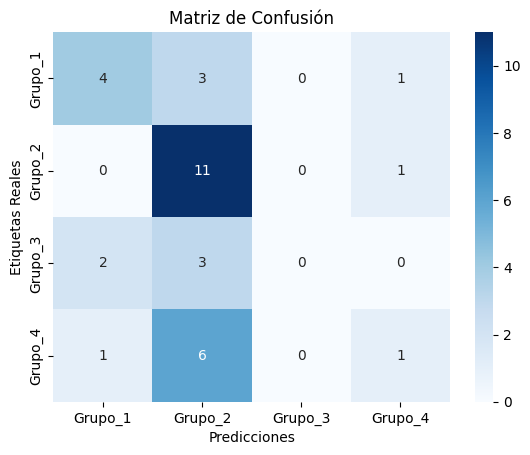

In [24]:
# Calcular la matriz de confusión
y_test_num = y_test.astype(int)
matrix = confusion_matrix(np.argmax(y_test_num, axis=1), np.argmax(y_pred, axis=1))
# Visualizar la matriz de confusión con seaborn
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Grupo_1', 'Grupo_2', 'Grupo_3', 'Grupo_4'], yticklabels=['Grupo_1', 'Grupo_2', 'Grupo_3', 'Grupo_4'])
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Reales")
plt.title("Matriz de Confusión")
plt.show()

# Funcion para predecir grupo y plotear



In [25]:
def predecir_grupo(iluminancia, temperatura, modelo):
    # Crear un DataFrame con las variables de entrada
    datos = pd.DataFrame({'Illuminance': [iluminancia], 'Temperature': [temperatura]})

    # Realizar la predicción utilizando el modelo
    predicciones = modelo.predict(datos)

    return predicciones[0]

# El input es un array de boolenos y los transforma a valores numéricos entre 1 y 4
def map_to_numeric(prediction):
    # Obtener el índice de la clase con la probabilidad más alta
    class_index = np.argmax(prediction)
    # Sumar 1 porque tus grupos van de 1 a 4
    return class_index + 1

# Función para asignar un color a cada grupo
def assign_color(group):
    colors = {1: 'red', 2: 'green', 3: 'blue', 4: 'purple'}
    return colors.get(group, 'black')  # Color negro si no hay coincidencia

## Creamos datos de prueba y los mapeamos

In [26]:
# Ejemplo de uso
np.random.seed(42)
num_muestras = 100
iluminancias = np.random.randint(0, 1000, num_muestras)
temperaturas = np.random.randint(0, 1000, num_muestras)

# Aplicar la función de predicción a los datos de ejemplo
predicciones = [predecir_grupo(iluminancia, temperatura, model) for iluminancia, temperatura in zip(iluminancias, temperaturas)]
# Mapear los grupos predichos a valores numéricos
numeric_predictions = [map_to_numeric(prediccion) for prediccion in predicciones]
#Mostramos las predicciones del modelo para los datos de prueba
print(numeric_predictions)

[1, 2, 4, 1, 1, 1, 4, 1, 4, 1, 2, 1, 2, 2, 1, 2, 1, 4, 4, 1, 4, 2, 4, 2, 2, 2, 4, 2, 1, 4, 1, 1, 2, 2, 1, 1, 4, 4, 4, 2, 1, 4, 4, 2, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 2, 4, 4, 1, 4, 1, 1, 2, 4, 2, 1, 1, 4, 2, 4, 4, 2, 1, 2, 4, 2, 2, 4, 4, 4, 1, 1, 1, 4, 4, 4, 2, 1, 2, 4, 1, 4, 4, 2, 4, 2, 4]


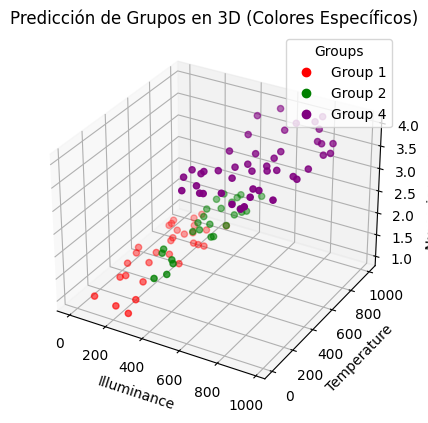

In [27]:
# Asignar un color a cada grupo
colors = [assign_color(group) for group in numeric_predictions]

# Crear un gráfico 3D con colores diferentes para cada grupo predicho
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(iluminancias, temperaturas, numeric_predictions, c=colors, marker='o')

ax.set_xlabel('Illuminance')
ax.set_ylabel('Temperature')
ax.set_zlabel('Numeric Prediction')

# Añadir leyenda para los colores de los grupos
legend_elements = [plt.Line2D([0], [0], marker='o', color=colors[i], label=f'Group {numeric_predictions[i]}', linestyle='None') for i in range(len(set(numeric_predictions)))]
ax.legend(handles=legend_elements, title='Groups', loc='upper right')

plt.title('Predicción de Grupos en 3D (Colores Específicos)')
plt.show()